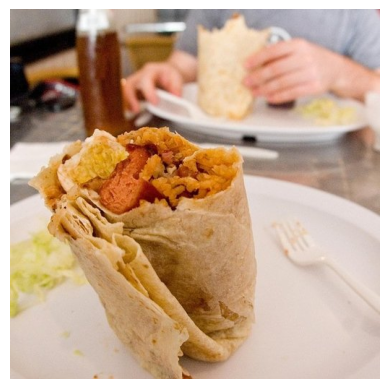

Predicted Class: Breakfast burrito, Confidence: 0.90


Enter the serving size for Breakfast burrito (e.g., '2 cup', '3 oz'):  1



Total Nutritional Values:
Calories: 420
Protein (g): 19.0
Carbs (g): 45
Fat (g): 22
Fiber (g): 4.0
Sugar (g): 3
Sodium (mg): 910


In [2]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import re
import collections

# Load the ResNet152 model (no pretrained weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet152(weights=None)  
model.fc = torch.nn.Linear(model.fc.in_features, 101) 
model = model.to(device)

# Load checkpoint (with weights_only=True)
checkpoint_path = "model_checkpoint5446.pth" 
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

# Remove 'module.' prefix if the checkpoint is wrapped with DataParallel
if isinstance(checkpoint, collections.OrderedDict):
    checkpoint = {k.replace('module.', ''): v for k, v in checkpoint.items()}

# Load the state_dict into the model
model.load_state_dict(checkpoint)

# Set model to evaluation mode
model.eval()

# Define transformations
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Food class labels
class_labels = [
    "Apple pie", "Baby back ribs", "Baklava", "Beef carpaccio", "Beef tartare",
    "Beet salad", "Beignets", "Bibimbap", "Bread pudding", "Breakfast burrito",
    "Bruschetta", "Caesar salad", "Cannoli", "Caprese salad", "Carrot cake",
    "Ceviche", "Cheesecake", "Cheese plate", "Chicken curry", "Chicken quesadilla",
    "Chicken wings", "Chocolate cake", "Chocolate mousse", "Churros", "Clam chowder",
    "Club sandwich", "Crab cakes", "Creme brulee", "Croque madame", "Cup cakes",
    "Deviled eggs", "Donuts", "Dumplings", "Edamame", "Eggs benedict", "Escargots",
    "Falafel", "Filet mignon", "Fish and chips", "Foie gras", "French fries",
    "French onion soup", "French toast", "Fried calamari", "Fried rice",
    "Frozen yogurt", "Garlic bread", "Gnocchi", "Greek salad",
    "Grilled cheese sandwich", "Grilled salmon", "Guacamole", "Gyoza", "Hamburger",
    "Hot and sour soup", "Hot dog", "Huevos rancheros", "Hummus", "Ice cream",
    "Lasagna", "Lobster bisque", "Lobster roll sandwich", "Macaroni and cheese",
    "Macarons", "Miso soup", "Mussels", "Nachos", "Omelette", "Onion rings",
    "Oysters", "Pad thai", "Paella", "Pancakes", "Panna cotta", "Peking duck",
    "Pho", "Pizza", "Pork chop", "Poutine", "Prime rib", "Pulled pork sandwich",
    "Ramen", "Ravioli", "Red velvet cake", "Risotto", "Samosa", "Sashimi",
    "Scallops", "Seaweed salad", "Shrimp and grits", "Spaghetti bolognese",
    "Spaghetti carbonara", "Spring rolls", "Steak", "Strawberry shortcake",
    "Sushi", "Tacos", "Takoyaki", "Tiramisu", "Tuna tartare", "Waffles"
]

# Load the nutrition dataset
nutrition_data = pd.read_csv('nutrition_data.csv')

# Function to standardize Serving Size descriptions into numeric grams
def standardize_serving_size(serving_size):
    match = re.match(r'(\d+(\.\d+)?)\s*(\w+|\d+)', serving_size)
    if match:
        value = float(match.group(1))
        unit = match.group(3).lower()
        
        if "oz" in unit:
            return value * 28.3495  # Convert ounces to grams
        elif "cup" in unit:
            return value * 240  # Approximate 1 cup to 240 grams
        elif "g" in unit:
            return value  # Already in grams
        elif "slice" in unit:
            return value * 30  # Approximate slice weight in grams
        elif "piece" in unit:
            return value * 30  # Approximate piece weight in grams
        elif "bowl" in unit:
            return value * 200  # Approximate bowl weight in grams
        else:
            return value  # Default to value if unit is unrecognized
    else:
        return 1  # Default to 1 if no match found

# Define the nutrient calculator function
def calculate_total_nutrients(dishes_quantities):
    total_nutrients = {
        "Calories": 0,
        "Protein (g)": 0,
        "Carbs (g)": 0,
        "Fat (g)": 0,
        "Fiber (g)": 0,
        "Sugar (g)": 0,
        "Sodium (mg)": 0
    }

    for dish, quantity in dishes_quantities.items():
        row = nutrition_data[nutrition_data['Dish'].str.lower() == dish.lower()]
        if not row.empty:
            total_nutrients["Calories"] += row["Calories"].values[0] * quantity 
            total_nutrients["Protein (g)"] += row["Protein (g)"].values[0] * quantity
            total_nutrients["Carbs (g)"] += row["Carbs (g)"].values[0] * quantity
            total_nutrients["Fat (g)"] += row["Fat (g)"].values[0] * quantity
            total_nutrients["Fiber (g)"] += row["Fiber (g)"].values[0] * quantity
            total_nutrients["Sugar (g)"] += row["Sugar (g)"].values[0] * quantity
            total_nutrients["Sodium (mg)"] += row["Sodium (mg)"].values[0] * quantity
        else:
            print(f"Warning: Dish '{dish}' not found in the dataset.")

    return total_nutrients

# Define total_intake variable to store the final nutritional values
total_intake = {}

# Function to predict the class and confidence of an input image
def predict_image(image_path, model, device):
    """Predict the class and confidence of an input image and display the image."""
    image = Image.open(image_path)

    # Ensure the image has 3 color channels
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply transformations and add batch dimension
    image_tensor = transform_test(image).unsqueeze(0).to(device)  # Move to the correct device

    with torch.no_grad():
        # Get model predictions
        output = model(image_tensor)  # Forward pass
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Convert logits to probabilities
        predicted_idx = torch.argmax(probabilities, dim=1).item()  # Get class index
        confidence = probabilities[0, predicted_idx].item()  # Get confidence score

    # Get the predicted class label from the class_labels list
    predicted_label = class_labels[predicted_idx]

    # Display the image with the prediction
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return predicted_label, confidence

# Specify the image path
image_path = "food-101/images/breakfast_burrito/1328.jpg"  # Change this to your test image

# Predict and display result
predicted_class, confidence = predict_image(image_path, model, device)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

try:
    # Take input for serving size
    quantity = input(f"Enter the serving size for {predicted_class} (e.g., '2 cup', '3 oz'): ").strip()
    quantity_in_grams = standardize_serving_size(quantity)
    
    # Calculate the nutritional values based on the input
    total_intake = calculate_total_nutrients({predicted_class: quantity_in_grams})
    
    # Display the total nutritional values
    print("\nTotal Nutritional Values:")
    for nutrient, value in total_intake.items():
        print(f"{nutrient}: {value}")

except ValueError:
    print("Invalid input. Please ensure the format is correct (e.g., '2 cup', '3 oz').")
except Exception as e:
    print(f"An error occurred: {e}")

## Deficiency Calculator

In [4]:
# Function to calculate the deficiency report based on user goals and total intake
def generate_deficiency_report_from_goals(user_goals, total_intake):
    report = {}
    for nutrient, goal_value in user_goals.items():
        total_value = total_intake.get(nutrient, 0)
        deficiency = goal_value - total_value
        report[nutrient] = {
            "User Goal": round(goal_value, 2),
            "Total Intake": round(total_value, 2),
            "Deficiency (or Excess)": round(deficiency, 2)
        }
    return report

# User Goals (nutritional targets)
user_goals = {
    "Caloric_Goal": 500,
    "Protein_Goal": 30.0,
    "Carb_Goal": 70.0,
    "Fat_Goal": 30.0,
    "Fiber_Goal": 10.0,
    "Sugar_Goal": 8.0,
    "Sodium_Goal": 900.0
}    
class_mappings = {
    "Calories": "Caloric_Goal",
    "Protein (g)": "Protein_Goal",
    "Carbs (g)": "Carb_Goal",
    "Fat (g)": "Fat_Goal",
    "Fiber (g)": "Fiber_Goal",
    "Sugar (g)": "Sugar_Goal",
    "Sodium (mg)": "Sodium_Goal"
}

# Generate the deficiency report
deficiency_report = generate_deficiency_report_from_goals(user_goals, total_intake)

# Display the report
print("\nDeficiency Report (Based on User Goals):")
for nutrient, details in deficiency_report.items():
    print(f"{nutrient}:")
    print(f"  User Goal: {details['User Goal']}")
    print(f"  Total Intake: {details['Total Intake']}")
    print(f"  Deficiency (or Excess): {details['Deficiency (or Excess)']}")


user_input = pd.DataFrame([{
    'Age': 40, 'Weight': 95, 'Height': 165, 'Caloric_Goal': 500, 'Carb_Goal': 280, 
    'Protein_Goal': 180, 'Fat_Goal': 85, 'Exercise_Duration': 50, 'Calories_Burned': 400, 
    'Water_Intake': 3.0, 'Sleep_Duration': 6, 'Vitamin_Intake': 1.8, 'Mineral_Intake': 2.2, 
    'Activity_Level': 'Moderately Active', 'Meal_Type': 'Breakfast', 
    'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None', 'Fiber_Goal': 10.0, 'Sugar_Goal': 8.0, 'Sodium_Goal': 900.0}])


Deficiency Report (Based on User Goals):
Calories:
  User Goal: 500
  Total Intake: 420
  Deficiency (or Excess): 80
Protein (g):
  User Goal: 30.0
  Total Intake: 19.0
  Deficiency (or Excess): 11.0
Carbs (g):
  User Goal: 70.0
  Total Intake: 45
  Deficiency (or Excess): 25.0
Fat (g):
  User Goal: 30.0
  Total Intake: 22
  Deficiency (or Excess): 8.0
Fiber (g):
  User Goal: 10.0
  Total Intake: 4.0
  Deficiency (or Excess): 6.0
Sugar (g):
  User Goal: 8.0
  Total Intake: 3
  Deficiency (or Excess): 5.0
Sodium (mg):
  User Goal: 900.0
  Total Intake: 910
  Deficiency (or Excess): -10.0


## Nutrition next meal

In [ ]:
# Load dataset
file_path = "/mnt/data/nutrition_tracking_data.csv"
data = pd.read_csv(file_path)

# Identify non-numeric values in numeric columns
numeric_cols = ['Age', 'Weight', 'Height', 'BMI', 'Exercise_Duration', 
                'Calories_Burned', 'Water_Intake', 'Sleep_Duration', 
                'Caloric_Goal', 'Carb_Goal', 'Protein_Goal', 'Fat_Goal',
                'Exercise_Intensity', 'Protein_Carb_Ratio', 'Fat_Carb_Ratio']

# Find problematic values
for col in numeric_cols:
    non_numeric = data[~data[col].astype(str).str.replace('.', '', 1).str.isnumeric()]
    if not non_numeric.empty:
        print(f"🚨 Non-numeric values found in '{col}':")
        print(non_numeric[[col]].head())

# Convert numeric columns properly
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values created after coercion
data.fillna(data.median(), inplace=True)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = "nutrition_tracking_data.csv"
data = pd.read_csv(file_path)

# Define features and targets
features = ['Age', 'Weight', 'Height', 'Caloric_Goal', 'Carb_Goal', 'Protein_Goal', 'Fat_Goal', 
            'Exercise_Duration', 'Calories_Burned', 'Water_Intake', 'Sleep_Duration', 
            'Vitamin_Intake', 'Mineral_Intake', 'Activity_Level', 'Meal_Type', 
            'Chronic_Conditions', 'Allergies', 'Medications']

targets = ['Calories', 'Carbohydrates', 'Proteins', 'Fats', 'Fiber', 'Sugar', 'Sodium']

# Clean numeric columns and handle non-numeric values
numeric_cols = ['Age', 'Weight', 'Height', 'Caloric_Goal', 'Carb_Goal', 'Protein_Goal', 
                'Fat_Goal', 'Exercise_Duration', 'Calories_Burned', 'Water_Intake', 
                'Sleep_Duration', 'Vitamin_Intake', 'Mineral_Intake']

# Convert numeric columns properly
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Verify missing values in 'Vitamin_Intake' and 'Mineral_Intake'
print(data[['Vitamin_Intake', 'Mineral_Intake']].isna().sum())

# Handle missing values
for col in numeric_cols:
    if data[col].isnull().sum() > 0:
        print(f"Filling missing values in {col} with median")
        # If columns have at least some valid values, fill NaN with median
        if col in ['Vitamin_Intake', 'Mineral_Intake']:
            # Check if the column has only NaN values
            if data[col].isna().sum() == len(data):
                # Drop columns if all values are NaN
                print(f"Dropping column {col} as it contains only NaN values.")
                data.drop(columns=[col], inplace=True)
            else:
                data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].median(), inplace=True)

# Update numeric_cols after dropping columns
numeric_cols = [col for col in numeric_cols if col in data.columns]

# Feature Engineering: Create new features
# BMI Calculation
data['BMI'] = data['Weight'] / (data['Height'] / 100) ** 2

# Exercise intensity feature
data['Exercise_Intensity'] = data['Calories_Burned'] / (data['Exercise_Duration'] + 1)

# Macronutrient ratios
data['Protein_Carb_Ratio'] = data['Protein_Goal'] / (data['Carb_Goal'] + 1)
data['Fat_Carb_Ratio'] = data['Fat_Goal'] / (data['Carb_Goal'] + 1)

# Update feature list with new features
features.extend(['BMI', 'Exercise_Intensity', 'Protein_Carb_Ratio', 'Fat_Carb_Ratio'])

# Remove dropped columns from features list
features = [col for col in features if col in data.columns]

# Check the data types and ensure numeric conversion
print(data.dtypes)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data[features], data[targets], test_size=0.2, random_state=42)

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Activity_Level', 'Meal_Type', 'Chronic_Conditions', 'Allergies', 'Medications']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols + ['BMI', 'Exercise_Intensity', 'Protein_Carb_Ratio', 'Fat_Carb_Ratio']),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Hyperparameter tuning grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5],
    'model__subsample': [0.8, 1.0]
}

models = {}
for target in targets:
    print(f"Training model for target: {target}")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor())
    ])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train[target])
    
    models[target] = grid_search.best_estimator_
    print(f"Best Hyperparameters for {target}: {grid_search.best_params_}")
    
    # Evaluate the model
    y_pred = models[target].predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[target], y_pred)
    
    print(f"\nOptimized Model Evaluation Metrics ({target} Target):")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}\n")

Vitamin_Intake    20000
Mineral_Intake    20000
dtype: int64
Filling missing values in Vitamin_Intake with median
Dropping column Vitamin_Intake as it contains only NaN values.
Filling missing values in Mineral_Intake with median
Dropping column Mineral_Intake as it contains only NaN values.
User_ID                object
Age                     int64
Gender                 object
Weight                float64
Height                float64
Activity_Level         object
Meal_Type              object
Date_Time              object
Food_Item              object
Food_Category          object
Calories                int64
Carbohydrates         float64
Proteins              float64
Fats                  float64
Fiber                 float64
Sugar                 float64
Sodium                float64
Exercise_Type          object
Exercise_Duration       int64
Calories_Burned         int64
Water_Intake          float64
Sleep_Duration        float64
Caloric_Goal            int64
Carb_Goal        

In [134]:
import joblib
import pandas as pd

# Load all models from 'Nutrition_Prediction.joblib'
loaded_models = joblib.load('Nutrition_Prediction.joblib')

# Define the targets list (the same list you used for training)
targets = ['Calories', 'Carbohydrates', 'Proteins', 'Fats', 'Fiber', 'Sugar', 'Sodium']

# Define a new user input (this time with different values)
user_input = pd.DataFrame([{
    'Age': 40, 'Weight': 95, 'Height': 165, 'Caloric_Goal': 500, 'Carb_Goal': 280, 
    'Protein_Goal': 180, 'Fat_Goal': 85, 'Exercise_Duration': 50, 'Calories_Burned': 400, 
    'Water_Intake': 3.0, 'Sleep_Duration': 6, 'Vitamin_Intake': 1.8, 'Mineral_Intake': 2.2, 
    'Activity_Level': 'Moderately Active', 'Meal_Type': 'Breakfast', 
    'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None'
}])

class_mappings = {
    "Caloric_Goal": "Calories",
    "Protein_Goal": "Proteins",
    "Carb_Goal": "Carbohydrates",
    "Fat_Goal": "Fats",
    "Fiber_Goal": "Fiber",
    "Sugar_Goal": "Sugar",
    "Sodium_Goal": "Sodium"
}

print("\nPredicted Nutritional Values for Next Meal:")
# Predict for each target using the loaded models
for target in loaded_models.keys():
    best_model = loaded_models[target]
    
    # Transform the user input
    user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
    
    # Make the prediction for the target variable
    prediction = best_model.named_steps['model'].predict(user_input_transformed)
    
    # Print the prediction for the current target
    print(f"{target}: {prediction[0]}")
    
meal_predictions = {}
print("="*50) 
print("Adjusted Predictions Based on Deficiencies:")
for deficiency_key, model_target in class_mappings.items():
    if model_target in loaded_models:
        best_model = loaded_models[model_target]
        
        # Transform user input using the preprocessor
        user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
        
        # Predict target value
        prediction = best_model.named_steps['model'].predict(user_input_transformed)
        
        # Get deficiency adjustment
        deficiency_adjustment = deficiency_report.get(deficiency_key, {}).get('Deficiency (or Excess)', 0)
        
        # Apply deficiency adjustment and ensure non-negative values
        adjusted_prediction = max(prediction[0] + deficiency_adjustment, 0)
        
        meal_predictions[model_target] = adjusted_prediction
        print(f"{model_target}: {adjusted_prediction:.2f} (Adjusted)")
    else:
        print(f"Warning: No model found for {model_target}")


Predicted Nutritional Values for Next Meal:
Calories: 431.9929423608559
Carbohydrates: 46.20467117850606
Proteins: 25.07798712932447
Fats: 15.355628765533554
Fiber: 7.587894507478002
Sugar: 13.715676618483371
Sodium: 479.91244504463344
Adjusted Predictions Based on Deficiencies:
Calories: 511.99 (Adjusted)
Proteins: 36.08 (Adjusted)
Carbohydrates: 71.20 (Adjusted)
Fats: 23.36 (Adjusted)
Fiber: 13.59 (Adjusted)
Sugar: 18.72 (Adjusted)
Sodium: 469.91 (Adjusted)


In [109]:
import joblib

# Save the trained models for each target
for target in targets:
    model_filename = f"{target}_model.joblib"
    joblib.dump(models[target], model_filename)
    print(f"Saved {target} model to {model_filename}")

Saved Calories model to Calories_model.joblib
Saved Carbohydrates model to Carbohydrates_model.joblib
Saved Proteins model to Proteins_model.joblib
Saved Fats model to Fats_model.joblib
Saved Fiber model to Fiber_model.joblib
Saved Sugar model to Sugar_model.joblib
Saved Sodium model to Sodium_model.joblib


In [110]:
# Load the saved models
loaded_models = {}
for target in targets:
    model_filename = f"{target}_model.joblib"
    loaded_models[target] = joblib.load(model_filename)
    print(f"Loaded {target} model from {model_filename}")

Loaded Calories model from Calories_model.joblib
Loaded Carbohydrates model from Carbohydrates_model.joblib
Loaded Proteins model from Proteins_model.joblib
Loaded Fats model from Fats_model.joblib
Loaded Fiber model from Fiber_model.joblib
Loaded Sugar model from Sugar_model.joblib
Loaded Sodium model from Sodium_model.joblib


In [111]:
import joblib

# Save all models in one file
all_models = {}

# Add all the trained models to the dictionary
for target in targets:
    all_models[target] = models[target]

# Save the dictionary with all models to 'Nutrition_Prediction.joblib'
joblib.dump(all_models, 'Nutrition_Prediction.joblib')
print("All models have been saved in one file: 'Nutrition_Prediction.joblib'")

All models have been saved in one file: 'Nutrition_Prediction.joblib'


In [112]:
# Load all models from 'Nutrition_Prediction.joblib'
loaded_models = joblib.load('Nutrition_Prediction.joblib')
print("All models have been loaded successfully.")

# Access the model for a specific target
target = 'Sodium'  
model_for_target = loaded_models[target]
print(f"Loaded model for {target}")

All models have been loaded successfully.
Loaded model for Sodium


In [114]:
import joblib
import pandas as pd

# Load all models from 'Nutrition_Prediction.joblib'
loaded_models = joblib.load('Nutrition_Prediction.joblib')

# Define a list of meals for the day
# Each meal is represented as a DataFrame with the same structure as the user input

daily_meals = pd.DataFrame([
    # Breakfast
    {
        'Age': 30, 'Weight': 75, 'Height': 170, 'Caloric_Goal': 2000, 'Carb_Goal': 250, 
        'Protein_Goal': 150, 'Fat_Goal': 70, 'Exercise_Duration': 30, 'Calories_Burned': 250, 
        'Water_Intake': 2, 'Sleep_Duration': 7, 'Vitamin_Intake': 1.5, 'Mineral_Intake': 1.5, 
        'Activity_Level': 'Moderately Active', 'Meal_Type': 'Breakfast', 
        'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None'
    },
    # Lunch
    {
        'Age': 30, 'Weight': 75, 'Height': 170, 'Caloric_Goal': 2000, 'Carb_Goal': 250, 
        'Protein_Goal': 150, 'Fat_Goal': 70, 'Exercise_Duration': 45, 'Calories_Burned': 350, 
        'Water_Intake': 2.5, 'Sleep_Duration': 7, 'Vitamin_Intake': 1.8, 'Mineral_Intake': 2, 
        'Activity_Level': 'Moderately Active', 'Meal_Type': 'Lunch', 
        'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None'
    },
    # Dinner
    {
        'Age': 30, 'Weight': 75, 'Height': 170, 'Caloric_Goal': 2000, 'Carb_Goal': 250, 
        'Protein_Goal': 150, 'Fat_Goal': 70, 'Exercise_Duration': 40, 'Calories_Burned': 300, 
        'Water_Intake': 2.0, 'Sleep_Duration': 7, 'Vitamin_Intake': 2.0, 'Mineral_Intake': 1.8, 
        'Activity_Level': 'Moderately Active', 'Meal_Type': 'Dinner', 
        'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None'
    }
])

# Define variables to store the total nutritional values for the day
total_calories = 0
total_carbs = 0
total_proteins = 0
total_fats = 0

# Predict nutritional values for each meal
print("\nPredicted Nutritional Values for Today's Meals:")
for meal in daily_meals.itertuples(index=False):
    meal_data = pd.DataFrame([meal._asdict()])
    
    print(f"\n{meal_data['Meal_Type'][0]}:")
    
    for target in loaded_models.keys():
        best_model = loaded_models[target]
        
        # Transform the user input
        meal_transformed = best_model.named_steps['preprocessor'].transform(meal_data)
        
        # Make the prediction for the target variable
        prediction = best_model.named_steps['model'].predict(meal_transformed)
        predicted_value = prediction[0]
        
        # Adjust the prediction based on the deficiency
        deficiency = deficiency_report.get(target, {}).get('deficiency', 0)
        adjusted_value = predicted_value + deficiency
        
        print(f"{target}: {adjusted_value:.2f} (Adjusted for deficiency)")

        # Add the predictions to the total values for the day
        if target == 'Calories':
            total_calories += adjusted_value
        elif target == 'Carbohydrates':
            total_carbs += adjusted_value
        elif target == 'Proteins':
            total_proteins += adjusted_value
        elif target == 'Fats':
            total_fats += adjusted_value

# Print the total nutritional values for the day
print("\nTotal Nutritional Values for the Day:")
print(f"Total Calories: {total_calories:.2f} kcal")
print(f"Total Carbohydrates: {total_carbs:.2f} g")
print(f"Total Proteins: {total_proteins:.2f} g")
print(f"Total Fats: {total_fats:.2f} g")


Predicted Nutritional Values for Today's Meals:

Breakfast:
Calories: 630.98 (Adjusted for deficiency)
Carbohydrates: 74.35 (Adjusted for deficiency)
Proteins: 35.27 (Adjusted for deficiency)
Fats: 20.18 (Adjusted for deficiency)
Fiber: 10.34 (Adjusted for deficiency)
Sugar: 28.80 (Adjusted for deficiency)
Sodium: 499.89 (Adjusted for deficiency)

Lunch:
Calories: 631.10 (Adjusted for deficiency)
Carbohydrates: 74.35 (Adjusted for deficiency)
Proteins: 35.16 (Adjusted for deficiency)
Fats: 20.10 (Adjusted for deficiency)
Fiber: 10.34 (Adjusted for deficiency)
Sugar: 28.82 (Adjusted for deficiency)
Sodium: 504.86 (Adjusted for deficiency)

Dinner:
Calories: 630.98 (Adjusted for deficiency)
Carbohydrates: 74.35 (Adjusted for deficiency)
Proteins: 35.17 (Adjusted for deficiency)
Fats: 20.10 (Adjusted for deficiency)
Fiber: 10.34 (Adjusted for deficiency)
Sugar: 28.81 (Adjusted for deficiency)
Sodium: 503.67 (Adjusted for deficiency)

Total Nutritional Values for the Day:
Total Calories: 

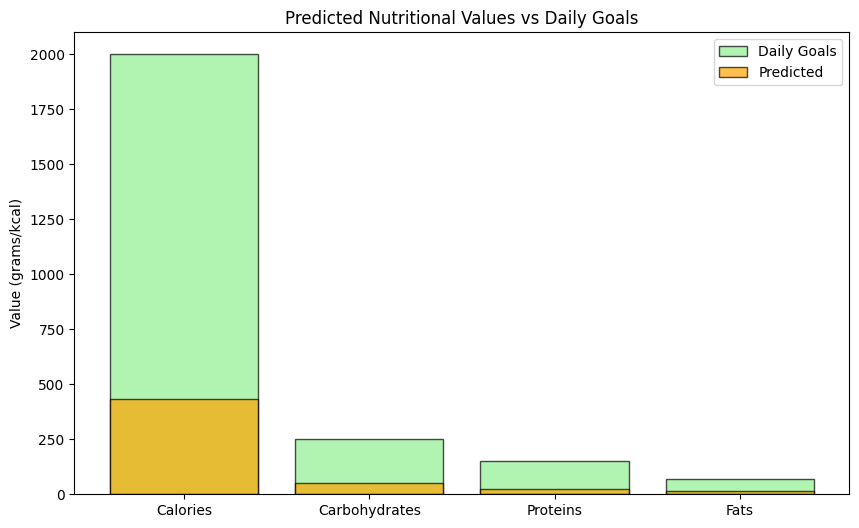

In [58]:
import matplotlib.pyplot as plt
predicted = [433.66, 49.33, 25.11, 15.10]
goals = [2000, 250, 150, 70]
nutrients = ['Calories', 'Carbohydrates', 'Proteins', 'Fats']

plt.figure(figsize=(10, 6))
plt.bar(nutrients, goals, alpha=0.7, label='Daily Goals', color='lightgreen', edgecolor='black')
plt.bar(nutrients, predicted, alpha=0.7, label='Predicted', color='orange', edgecolor='black')
plt.title("Predicted Nutritional Values vs Daily Goals")
plt.ylabel("Value (grams/kcal)")
plt.legend()
plt.show()

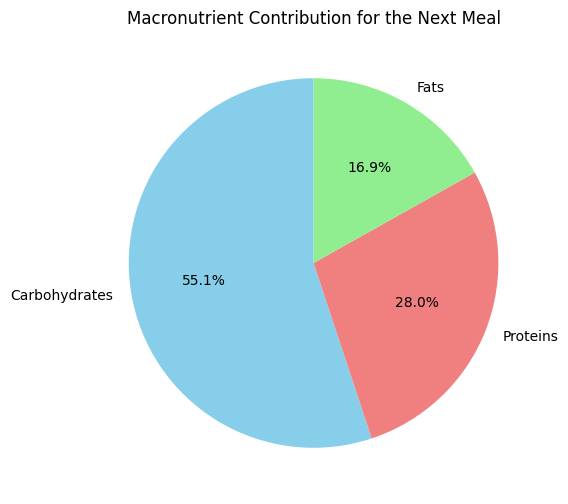

In [59]:
labels = ['Carbohydrates', 'Proteins', 'Fats']
values = [49.33, 25.11, 15.10]
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title("Macronutrient Contribution for the Next Meal")
plt.show()

## Disease Risk Prediction

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

# Add derived features
def add_features(data):
    print("=== Adding Features ===")
    # Calculate BMI
    data['BMI'] = data['Weight'] / ((data['Height'] / 100) ** 2)

    # Encode activity levels
    activity_mapping = {
        'Sedentary': 1,
        'Lightly Active': 2,
        'Moderately Active': 3,
        'Very Active': 4
    }
    data['Activity_Level_Encoded'] = data['Activity_Level'].map(activity_mapping)
    data['Activity_Level_Encoded'] = data['Activity_Level_Encoded'].fillna(1)

    # Calories per Activity Level
    data['Calories_per_Activity'] = data['Calories'] / data['Activity_Level_Encoded']
    data['Calories_per_Activity'] = data['Calories_per_Activity'].fillna(data['Calories_per_Activity'].mean())

    return data

data = add_features(data)

# Define features and targets
features = ['Age', 'Weight', 'Height', 'Calories', 'Carbohydrates', 'Proteins', 'Fats',
            'Sleep_Duration', 'Water_Intake', 'BMI', 'Calories_per_Activity']
conditions = ['Diabetes', 'High Cholesterol', 'Hypertension', 'Obesity', 'Arthritis', 'Asthma']

X = data[features]
y = pd.DataFrame()
for condition in conditions:
    y[condition] = data['Chronic_Conditions'].apply(lambda x: 1 if condition in str(x) else 0)

# Preprocess features
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), features)
])

X_transformed = preprocessor.fit_transform(X)

# Train class-specific models
def train_class_specific_models(X, y, conditions):
    print("=== Training Class-Specific Models ===")
    reports = {}

    for idx, condition in enumerate(conditions):
        print(f"\n--- Condition: {condition} ---")
        
        # Extract features and target for this condition
        y_condition = y.iloc[:, idx]
        
        # Apply oversampling
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X, y_condition)
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
        )
        
        # Train a RandomForest model for this condition
        clf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")
        clf.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, zero_division=0)
        print(report)
        reports[condition] = report

    return reports

# Apply resampling and train class-specific models
class_specific_reports = train_class_specific_models(X_transformed, y, conditions)

=== Adding Features ===
=== Training Class-Specific Models ===

--- Condition: Diabetes ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3188
           1       0.99      0.97      0.98      3188

    accuracy                           0.98      6376
   macro avg       0.98      0.98      0.98      6376
weighted avg       0.98      0.98      0.98      6376


--- Condition: High Cholesterol ---
              precision    recall  f1-score   support

           0       0.67      0.79      0.73      2397
           1       0.74      0.62      0.67      2397

    accuracy                           0.70      4794
   macro avg       0.71      0.70      0.70      4794
weighted avg       0.71      0.70      0.70      4794


--- Condition: Hypertension ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3223
           1       0.99      0.96      0.98      3222

    accuracy        

In [64]:
import joblib

# Dictionary to store all models and the preprocessor
models_to_save = {'models': {}, 'preprocessor': preprocessor}

# Save each trained model into the dictionary
for idx, condition in enumerate(conditions):
    # Train your models for each condition as described earlier (assuming `clf` is the trained model)
    y_condition = y.iloc[:, idx]
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_transformed, y_condition)
    X_train, _, y_train, _ = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )
    
    clf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")
    clf.fit(X_train, y_train)
    
    # Store the model in the dictionary
    models_to_save['models'][condition] = clf

# Save the dictionary to a single file
output_file = "diabetes_risk_model.pkl"
joblib.dump(models_to_save, output_file)

print(f"All models and the preprocessor have been saved to {output_file}.")

All models and the preprocessor have been saved to diabetes_risk_model.pkl.


In [65]:
import joblib
import pandas as pd

# Load the saved models and preprocessor
loaded_data = joblib.load("diabetes_risk_model.pkl")
models = loaded_data['models']  
preprocessor = loaded_data['preprocessor'] 

# Example user input
user_input = {
    "Age": 45,
    "Weight": 70,
    "Height": 170,
    "Calories": 2000,
    "Carbohydrates": 250,
    "Proteins": 70,
    "Fats": 50,
    "Sleep_Duration": 7,
    "Water_Intake": 2.5,
    "BMI": 70 / (1.7 ** 2), 
    "Calories_per_Activity": 2000 / 3 
}

# Convert the input to a DataFrame
user_df = pd.DataFrame([user_input])

# Preprocess the input using the loaded preprocessor
user_transformed = preprocessor.transform(user_df)

# Predict for each condition
predictions = {}
for condition, model in models.items():
    prediction = model.predict(user_transformed)
    predictions[condition] = "Yes" if prediction[0] == 1 else "No"

# Output the predictions
print("Predicted Conditions:")
for condition, result in predictions.items():
    print(f"{condition}: {result}")

Predicted Conditions:
Diabetes: No
High Cholesterol: No
Hypertension: No
Obesity: No
Arthritis: No
Asthma: No


## Mental health status

In [66]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek

# Binary target for mental health status
data['Mental_Health_Status'] = data['Medications'].apply(lambda x: 1 if 'Antidepressants' in str(x) else 0)
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1}).fillna(-1)

# Feature Engineering
data['Calories_Per_Exercise'] = data['Calories'] / (data['Exercise_Duration'] + 1)
data['Calories_Per_Sleep'] = data['Calories'] / (data['Sleep_Duration'] + 1)
data['Age_Binned'] = pd.cut(data['Age'], bins=[0, 18, 35, 50, 65, 100], labels=False, include_lowest=True)

# Define features and target variable
features = ['Age', 'Weight', 'Height', 'Calories', 'Carbohydrates', 'Proteins',
            'Fats', 'Exercise_Duration', 'Calories_Burned', 'Water_Intake',
            'Sleep_Duration', 'Gender', 'Activity_Level', 'Meal_Type',
            'Calories_Per_Exercise', 'Calories_Per_Sleep', 'Age_Binned']
target = 'Mental_Health_Status'

X = data[features]
y = data[target]

# One-hot encode categorical features
categorical_features = ['Activity_Level', 'Meal_Type']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Handle missing values
X.fillna(X.mean(), inplace=True)

# Resampling using SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Feature Selection with RandomForest
feature_selector = RandomForestClassifier(random_state=42)
feature_selector.fit(X_resampled, y_resampled)
important_features = SelectFromModel(feature_selector, threshold='mean').get_support()
selected_features = X.columns[important_features]

# Update dataset with selected features
X_resampled = X_resampled[selected_features]
X_test = X[selected_features]

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize individual models
lgbm = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    is_unbalance=True,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    class_weight={0: 1, 1: 3},
    random_state=42
)

xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=3,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    eval_metric='logloss',
    random_state=42
)

log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Combine models into a voting classifier
ensemble = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('xgb', xgb),
        ('log_reg', log_reg)
    ],
    voting='soft'  
)

# Train the ensemble model
ensemble.fit(X_train, y_train)

# Predict and evaluate
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)[:, 1]

# Evaluate ensemble performance
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred_proba)
f1 = f1_score(y, y_pred, average='weighted')
classification_report_result = classification_report(y, y_pred)

# Optimal threshold adjustment
precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Adjusted predictions
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)
adjusted_classification_report = classification_report(y, y_pred_adjusted)

# Output results
print(f"Ensemble Model Accuracy: {accuracy}")
print(f"Ensemble ROC AUC Score: {roc_auc}")
print(f"Weighted F1 Score: {f1}")
print("Classification Report (Default Threshold):")
print(classification_report_result)

print(f"Optimal Threshold: {optimal_threshold}")
print("Classification Report (Adjusted Threshold):")
print(adjusted_classification_report)

[LightGBM] [Info] Number of positive: 8535, number of negative: 8517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3237
[LightGBM] [Info] Number of data points in the train set: 17052, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750396 -> initscore=1.100723
[LightGBM] [Info] Start training from score 1.100723
Ensemble Model Accuracy: 0.814
Ensemble ROC AUC Score: 0.9289491173464972
Weighted F1 Score: 0.8157475866638885
Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     11945
           1       0.71      0.90      0.80      8055

    accuracy                           0.81     20000
   macro avg       0.82      0.83      0.81     20000
weighted avg       0.84      0.81      0.82     20000

Optimal Threshold: 0.6000373

In [68]:
import joblib

# Save the ensemble model, selected features, and preprocessor
model_metadata = {
    'model': ensemble,
    'selected_features': selected_features,
    'feature_selector': feature_selector
}

# Save the model to a file
joblib.dump(model_metadata, 'Mental_health.pkl')

print("Model and metadata saved successfully!")

Model and metadata saved successfully!


In [69]:
loaded_data = joblib.load('Mental_health.pkl')

# Extract the model and features
ensemble_model = loaded_data['model']
selected_features = loaded_data['selected_features']

In [70]:
import joblib
import pandas as pd

# Load the saved model
model_data = joblib.load('Mental_health.pkl')

# Extract the model and selected features
ensemble_model = model_data['model']
selected_features = model_data['selected_features']

# Example user input
user_input = {
    'Age': 28,
    'Weight': 68,
    'Height': 172,
    'Calories': 1800,
    'Carbohydrates': 220,
    'Proteins': 65,
    'Fats': 60,
    'Exercise_Duration': 45,
    'Calories_Burned': 400,
    'Water_Intake': 2.8,
    'Sleep_Duration': 7,
    'Gender': 'Male',  
    'Activity_Level': 'Very Active',  
    'Meal_Type': 'Breakfast', 
    'Calories_Per_Exercise': 40.0,  
    'Calories_Per_Sleep': 257.14,  
    'Age_Binned': 2  
}

# Convert Gender to numerical format
user_input['Gender'] = 0 if user_input['Gender'] == 'Male' else 1

# Convert input into a DataFrame
user_df = pd.DataFrame([user_input])

# One-hot encode categorical features
user_df = pd.get_dummies(user_df, columns=['Activity_Level', 'Meal_Type'], drop_first=True)

# Ensure the input columns align with the training data
missing_cols = set(selected_features) - set(user_df.columns)
for col in missing_cols:
    user_df[col] = 0

# Retain only the selected features
user_df = user_df[selected_features]

# Make predictions using the loaded ensemble model
user_pred = ensemble_model.predict(user_df)
user_pred_proba = ensemble_model.predict_proba(user_df)[:, 1]

# Interpret and output the result
status = "Risk" if user_pred[0] == 1 else "Not at risk"

print(f"User mental health status: {status}")
print(f"Prediction Probability: {user_pred_proba[0]:.2f}")

User mental health status: Risk
Prediction Probability: 0.51


## Food Recommendation 

In [135]:
import joblib
import pandas as pd
import random

# Load the Nutrition Tracking Data
nutrition_data = pd.read_csv('nutrition_data.csv')

# Define class mappings
class_mappings = {
    "Caloric_Goal": "Calories",
    "Protein_Goal": "Proteins",
    "Carb_Goal": "Carbohydrates",
    "Fat_Goal": "Fats",
    "Fiber_Goal": "Fiber",
    "Sugar_Goal": "Sugar",
    "Sodium_Goal": "Sodium"
}

# Rename columns to match expected names
nutrition_data.rename(columns={
    'Dish': 'Food_Item',
    'Carbs (g)': 'Carbohydrates',
    'Protein (g)': 'Proteins',
    'Fat (g)': 'Fats',
    'Fiber (g)': 'Fiber',
    'Sugar (g)': 'Sugar',
    'Sodium (mg)': 'Sodium'
}, inplace=True)

# Load all models from 'Nutrition_Prediction.joblib'
loaded_models = joblib.load('Nutrition_Prediction.joblib')

# Preprocess the dataset
def preprocess_data(data):
    relevant_columns = ["Food_Item"] + list(class_mappings.values())
    data = data[relevant_columns].dropna()
    
    for col in class_mappings.values():
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    return data.dropna()

available_foods = preprocess_data(nutrition_data)

# Define a new user input
user_input = pd.DataFrame([{
    'Age': 40, 'Weight': 95, 'Height': 165, 'Caloric_Goal': 2200, 'Carb_Goal': 280, 
    'Protein_Goal': 180, 'Fat_Goal': 85, 'Exercise_Duration': 50, 'Calories_Burned': 400, 
    'Water_Intake': 3.0, 'Sleep_Duration': 6, 'Vitamin_Intake': 1.8, 'Mineral_Intake': 2.2, 
    'Activity_Level': 'Moderately Active', 'Meal_Type': 'Breakfast', 
    'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None'
}])

# Predict baseline nutrition values using the loaded models
baseline_nutrition = {}
for deficiency_key, model_target in class_mappings.items():
    if model_target in loaded_models:
        best_model = loaded_models[model_target]
        user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
        prediction = best_model.named_steps['model'].predict(user_input_transformed)
        baseline_nutrition[model_target] = prediction[0]
    else:
        print(f"Warning: No model found for {model_target}")

# Print baseline predictions
print("\nPredicted Nutritional Values for Next Meal:")
for target, value in baseline_nutrition.items():
    print(f"{target}: {value:.2f}")

print("="*50)
print("Adjusted Predictions Based on Deficiencies:")

adjusted_nutrition = {}
for deficiency_key, model_target in class_mappings.items():
    deficiency_adjustment = deficiency_report.get(deficiency_key, {}).get('Deficiency (or Excess)', 0)
    adjusted_nutrition[model_target] = max(0, baseline_nutrition.get(model_target, 0) + deficiency_adjustment)
    print(f"{model_target}: {adjusted_nutrition[model_target]:.2f} (Adjusted)")

print("="*50)

def recommend_meal(data, nutrition_targets):
    best_meal = None
    best_diff = float('inf')
    
    for _ in range(100):  # Iteratively find a closer match
        meal_items = data.sample(random.randint(2, 4))
        total_nutrition = meal_items[list(class_mappings.values())].sum()
        diff = (pd.Series(nutrition_targets) - total_nutrition).abs().sum()
        
        if diff < best_diff:
            best_meal = meal_items
            best_diff = diff
    
    return best_meal

# Generate meal plan
meal_types = ["Meal 1", "Meal 2", "Meal 3"]
meal_plan = {}

for meal_type in meal_types:
    user_input['Meal_Type'] = meal_type
    
    for deficiency_key, model_target in class_mappings.items():
        if model_target in loaded_models:
            best_model = loaded_models[model_target]
            user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
            baseline_nutrition[model_target] = best_model.named_steps['model'].predict(user_input_transformed)[0]
    
    for target in baseline_nutrition:
        baseline_nutrition[target] = max(0, baseline_nutrition[target] + deficiency_report.get(target, {}).get('Deficiency (or Excess)', 0))
    
    meal_plan[meal_type] = recommend_meal(available_foods, baseline_nutrition)

for meal_type, items in meal_plan.items():
    items = items.reset_index(drop=True)
    total_nutrition = items[list(class_mappings.values())].sum()
    print(f"{meal_type}:")
    print(items)
    print(f"Total Nutrition for {meal_type}: {total_nutrition.to_dict()}\n")


Predicted Nutritional Values for Next Meal:
Calories: 431.99
Proteins: 25.34
Carbohydrates: 48.66
Fats: 15.10
Fiber: 7.35
Sugar: 13.96
Sodium: 485.66
Adjusted Predictions Based on Deficiencies:
Calories: 511.99 (Adjusted)
Proteins: 36.34 (Adjusted)
Carbohydrates: 73.66 (Adjusted)
Fats: 23.10 (Adjusted)
Fiber: 13.35 (Adjusted)
Sugar: 18.96 (Adjusted)
Sodium: 475.66 (Adjusted)
Meal 1:
    Food_Item  Calories  Proteins  Carbohydrates  Fats  Fiber  Sugar  Sodium
0  bruschetta       150       5.0             20     7    2.0      3     250
1   cup_cakes       280       3.0             42    11    1.0     34     210
Total Nutrition for Meal 1: {'Calories': 430.0, 'Proteins': 8.0, 'Carbohydrates': 62.0, 'Fats': 18.0, 'Fiber': 3.0, 'Sugar': 37.0, 'Sodium': 460.0}

Meal 2:
      Food_Item  Calories  Proteins  Carbohydrates  Fats  Fiber  Sugar  Sodium
0  creme_brulee       320       4.0             32    19    0.0     28      95
1       mussels       150      20.0              6     4    0.0    

## Combined Code 

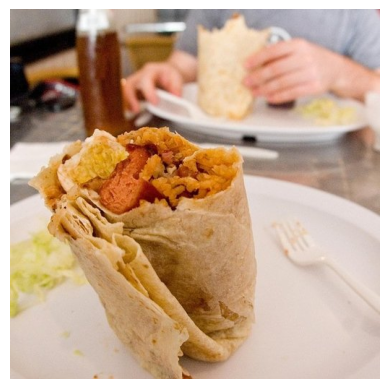

Predicted Class: Breakfast burrito, Confidence: 0.90


Enter the quantity in grams for Breakfast burrito:  500



Total Nutritional Values:
Calories: 750.00
Protein (g): 33.93
Carbs (g): 80.36
Fat (g): 39.29
Fiber (g): 7.14
Sugar (g): 5.36
Sodium (mg): 1625.00

Deficiency Report (Based on User Goals):
Caloric_Goal:
  User Goal: 500
  Total Intake: 750.0
  Deficiency (or Excess): -250.0
Carb_Goal:
  User Goal: 280
  Total Intake: 80.36
  Deficiency (or Excess): 199.64
Protein_Goal:
  User Goal: 180
  Total Intake: 33.93
  Deficiency (or Excess): 146.07
Fat_Goal:
  User Goal: 85
  Total Intake: 39.29
  Deficiency (or Excess): 45.71
Fiber_Goal:
  User Goal: 10.0
  Total Intake: 7.14
  Deficiency (or Excess): 2.86
Sugar_Goal:
  User Goal: 8.0
  Total Intake: 5.36
  Deficiency (or Excess): 2.64
Sodium_Goal:
  User Goal: 900.0
  Total Intake: 1625.0
  Deficiency (or Excess): -725.0

Predicted Nutritional Values for Next Meal:
Calories: 431.9929423608559
Carbohydrates: 46.20467117850606
Proteins: 25.07798712932447
Fats: 15.355628765533554
Fiber: 7.587894507478002
Sugar: 13.715676618483371
Sodium: 479.91

In [5]:
import joblib
import random
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import re
import collections

# Load models and preprocessors
nutrition_models = joblib.load('Nutrition_Prediction.joblib')  # For nutrition-related predictions
diabetes_model_data = joblib.load("diabetes_risk_model.pkl")  # For diabetes risk prediction
mental_health_model_data = joblib.load('Mental_health.pkl')  # For mental health prediction
nutrition_data = pd.read_csv('nutrition_data.csv')

user_input = pd.DataFrame([{
    'Age': 40, 'Weight': 95, 'Height': 165, 'Caloric_Goal': 500, 'Carb_Goal': 280, 
    'Protein_Goal': 180, 'Fat_Goal': 85, 'Exercise_Duration': 50, 'Calories_Burned': 400, 
    'Water_Intake': 3.0, 'Sleep_Duration': 6, 'Vitamin_Intake': 1.8, 'Mineral_Intake': 2.2, 
    'Activity_Level': 'Moderately Active', 'Meal_Type': 'Breakfast', 
    'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None', 
    'Fiber_Goal': 10.0, 'Sugar_Goal': 8.0, 'Sodium_Goal': 900.0, 'Calories': 400, 
    'Proteins': 150, 'Carbohydrates': 230, 'Fats': 70, 'Fiber': 8.0, 'Sugar': 7.0, 'Sodium': 850.0}])

# Load the ResNet152 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet152(weights=None)  # No pretrained weights since it's custom-trained
model.fc = torch.nn.Linear(model.fc.in_features, 101)  # Output layer for 101 classes
model = model.to(device)

# Load checkpoint
checkpoint_path = "model_checkpoint5446.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

# Remove 'module.' prefix if needed
if isinstance(checkpoint, collections.OrderedDict):
    checkpoint = {k.replace('module.', ''): v for k, v in checkpoint.items()}

model.load_state_dict(checkpoint)
model.eval()

# Define transformations
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Food class labels
class_labels = [
    "Apple pie", "Baby back ribs", "Baklava", "Beef carpaccio", "Beef tartare",
    "Beet salad", "Beignets", "Bibimbap", "Bread pudding", "Breakfast burrito",
    "Bruschetta", "Caesar salad", "Cannoli", "Caprese salad", "Carrot cake",
    "Ceviche", "Cheesecake", "Cheese plate", "Chicken curry", "Chicken quesadilla",
    "Chicken wings", "Chocolate cake", "Chocolate mousse", "Churros", "Clam chowder",
    "Club sandwich", "Crab cakes", "Creme brulee", "Croque madame", "Cup cakes",
    "Deviled eggs", "Donuts", "Dumplings", "Edamame", "Eggs benedict", "Escargots",
    "Falafel", "Filet mignon", "Fish and chips", "Foie gras", "French fries",
    "French onion soup", "French toast", "Fried calamari", "Fried rice",
    "Frozen yogurt", "Garlic bread", "Gnocchi", "Greek salad",
    "Grilled cheese sandwich", "Grilled salmon", "Guacamole", "Gyoza", "Hamburger",
    "Hot and sour soup", "Hot dog", "Huevos rancheros", "Hummus", "Ice cream",
    "Lasagna", "Lobster bisque", "Lobster roll sandwich", "Macaroni and cheese",
    "Macarons", "Miso soup", "Mussels", "Nachos", "Omelette", "Onion rings",
    "Oysters", "Pad thai", "Paella", "Pancakes", "Panna cotta", "Peking duck",
    "Pho", "Pizza", "Pork chop", "Poutine", "Prime rib", "Pulled pork sandwich",
    "Ramen", "Ravioli", "Red velvet cake", "Risotto", "Samosa", "Sashimi",
    "Scallops", "Seaweed salad", "Shrimp and grits", "Spaghetti bolognese",
    "Spaghetti carbonara", "Spring rolls", "Steak", "Strawberry shortcake",
    "Sushi", "Tacos", "Takoyaki", "Tiramisu", "Tuna tartare", "Waffles"
]

# Load the dataset
nutrition_data = pd.read_csv('nutrition_data.csv')

# Function to extract serving size in grams
def extract_serving_size(serving_size):
    match = re.search(r'(\d+)\s*g', str(serving_size))
    if match:
        return float(match.group(1))
    unit_conversions = {"oz": 28.3495, "cup": 240, "slice": 30, "piece": 30, "bowl": 200}
    match = re.match(r'(\d+(\.\d+)?)\s*(\w+)', str(serving_size))
    if match:
        value = float(match.group(1))
        unit = match.group(3).lower()
        return value * unit_conversions.get(unit, value)
    return None

# Apply function to standardize serving sizes
nutrition_data["Serving Size (g)"] = nutrition_data["Serving Size"].apply(extract_serving_size)

# Function to calculate total nutrient intake
def calculate_total_nutrients(dish, quantity, total_intake):
    row = nutrition_data[nutrition_data['Dish'].str.lower() == dish.lower()]
    if not row.empty:
        ref_serving_size = row["Serving Size (g)"].values[0]
        scale_factor = quantity / ref_serving_size if ref_serving_size else 1
        for nutrient in ["Calories", "Protein (g)", "Carbs (g)", "Fat (g)", "Fiber (g)", "Sugar (g)", "Sodium (mg)"]:
            total_intake[nutrient] += row[nutrient].values[0] * scale_factor
    else:
        print(f"Warning: Dish '{dish}' not found in the dataset.")
    return total_intake

# Function to predict image class and calculate nutrition
def predict_image(image_path, model, device, total_intake):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_tensor = transform_test(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_idx].item()
    
    predicted_label = class_labels[predicted_idx]
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print(f"Predicted Class: {predicted_label}, Confidence: {confidence:.2f}")
    
    quantity = float(input(f"Enter the quantity in grams for {predicted_label}: "))
    total_intake = calculate_total_nutrients(predicted_label, quantity, total_intake)
    
    print("\nTotal Nutritional Values:")
    for nutrient, value in total_intake.items():
        print(f"{nutrient}: {value:.2f}")
    
    return predicted_label, confidence, total_intake

# Initialize total intake dictionary
total_intake = {"Calories": 0, "Protein (g)": 0, "Carbs (g)": 0, "Fat (g)": 0, "Fiber (g)": 0, "Sugar (g)": 0, "Sodium (mg)": 0}

# Provide an image path for testing
image_path = "food-101/images/breakfast_burrito/1328.jpg"

# Predict and display result
predicted_class, confidence, total_intake = predict_image(image_path, model, device, total_intake)

def generate_deficiency_report_from_goals(user_input, total_intake, class_mappings2):
    report = {}
    
    # Extract the user goals directly from the user_input DataFrame (assumes only one row)
    user_goals = user_input.iloc[0].to_dict()
    
    # Iterate over the user goals and generate the deficiency report
    for nutrient, goal_value in user_goals.items():
        if nutrient in class_mappings2:  # Ensure nutrient is in the mappings
            # Map user goals to the corresponding total intake field using class_mappings
            mapped_nutrient = class_mappings2[nutrient]
            total_value = total_intake.get(mapped_nutrient, 0)
            deficiency = goal_value - total_value
            report[nutrient] = {
                "User Goal": round(goal_value, 2),
                "Total Intake": round(total_value, 2),
                "Deficiency (or Excess)": round(deficiency, 2)
            }
    
    return report

# Class Mappings to align the goal and intake values
class_mappings2 = {
    "Caloric_Goal": "Calories",
    "Protein_Goal": "Protein (g)",
    "Carb_Goal": "Carbs (g)",
    "Fat_Goal": "Fat (g)",
    "Fiber_Goal": "Fiber (g)",
    "Sugar_Goal": "Sugar (g)",
    "Sodium_Goal": "Sodium (mg)"
}

# Generate the deficiency report
deficiency_report = generate_deficiency_report_from_goals(user_input, total_intake, class_mappings2)

# Display the report
print("\nDeficiency Report (Based on User Goals):")
for nutrient, details in deficiency_report.items():
    print(f"{nutrient}:")
    print(f"  User Goal: {details['User Goal']}")
    print(f"  Total Intake: {details['Total Intake']}")
    print(f"  Deficiency (or Excess): {details['Deficiency (or Excess)']}")

# Extract relevant data from the loaded diabetes and mental health models
diabetes_models = diabetes_model_data['models']
diabetes_preprocessor = diabetes_model_data['preprocessor']
ensemble_model = mental_health_model_data['model']
mental_health_selected_features = mental_health_model_data['selected_features']

class_mappings = {
    "Caloric_Goal": "Calories",
    "Protein_Goal": "Proteins",
    "Carb_Goal": "Carbohydrates",
    "Fat_Goal": "Fats",
    "Fiber_Goal": "Fiber",
    "Sugar_Goal": "Sugar",
    "Sodium_Goal": "Sodium"
}

nutrition_data.rename(columns={
    'Dish': 'Food_Item',
    'Carbs (g)': 'Carbohydrates',
    'Protein (g)': 'Proteins',
    'Fat (g)': 'Fats',
    'Fiber (g)': 'Fiber',
    'Sugar (g)': 'Sugar',
    'Sodium (mg)': 'Sodium'
}, inplace=True)

# Ensure missing columns are added with default values
required_columns = [
    'Calories', 'Carbohydrates', 'Proteins', 'Fats', 'BMI', 'Calories_per_Activity'
]

for col in required_columns:
    if col not in user_input.columns:
        if col == 'BMI':
            # Calculate BMI if missing
            user_input['BMI'] = user_input['Weight'] / (user_input['Height'] / 100) ** 2
        elif col == 'Calories_per_Activity':
            # Example calculation for calories per activity
            user_input['Calories_per_Activity'] = user_input['Calories'] / 3  # Adjust this as needed
        else:
            # Add default value (e.g., 0 or mean value for others)
            user_input[col] = 0

# Preprocess the dataset
def preprocess_data(data):
    relevant_columns = ["Food_Item"] + list(class_mappings.values())
    data = data[relevant_columns].dropna()
    
    for col in class_mappings.values():
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    return data.dropna()

available_foods = preprocess_data(nutrition_data)

# Predict baseline nutrition values using the loaded models
baseline_nutrition = {}
for deficiency_key, model_target in class_mappings.items():
    if model_target in nutrition_models:
        best_model = nutrition_models[model_target]
        user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
        prediction = best_model.named_steps['model'].predict(user_input_transformed)
        baseline_nutrition[model_target] = prediction[0]
    else:
        print(f"Warning: No model found for {model_target}")
        
# Perform nutrition prediction for each target
print("\nPredicted Nutritional Values for Next Meal:")
meal_predictions = {}
for target in nutrition_models.keys():
    best_model = nutrition_models[target]
    user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
    prediction = best_model.named_steps['model'].predict(user_input_transformed)
    meal_predictions[target] = prediction[0]
    print(f"{target}: {prediction[0]}")

# Adjust predictions based on deficiencies (if applicable)
print("="*50)

adjusted_nutrition = {}
for deficiency_key, model_target in class_mappings.items():
    deficiency_adjustment = deficiency_report.get(deficiency_key, {}).get('Deficiency (or Excess)', 0)
    adjusted_nutrition[model_target] = max(0, baseline_nutrition.get(model_target, 0) + deficiency_adjustment)
    
print("Adjusted Predictions Based on Deficiencies:")
for deficiency_key, model_target in class_mappings.items():
    if model_target in nutrition_models:
        best_model = nutrition_models[model_target]
        user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
        prediction = best_model.named_steps['model'].predict(user_input_transformed)
        deficiency_adjustment = deficiency_report.get(deficiency_key, {}).get('Deficiency (or Excess)', 0)
        adjusted_prediction = max(prediction[0] + deficiency_adjustment, 0)
        meal_predictions[model_target] = adjusted_prediction
        print(f"{model_target}: {adjusted_prediction:.2f} (Adjusted)")
    else:
        print(f"Warning: No model found for {model_target}")

# Now handle diabetes risk prediction
print("="*50)
print("Diabetes Risk Prediction:")
user_input_df = pd.DataFrame([user_input.iloc[0].to_dict()])
user_transformed = diabetes_preprocessor.transform(user_input_df)

diabetes_predictions = {}
for condition, model in diabetes_models.items():
    prediction = model.predict(user_transformed)
    diabetes_predictions[condition] = "Yes" if prediction[0] == 1 else "No"

# Output diabetes predictions
for condition, result in diabetes_predictions.items():
    print(f"{condition}: {result}")

# Mental health prediction
print("="*50)
print("Mental Health Prediction:")

# Ensure Gender exists and handle the case if it's missing
if 'Gender' in user_input.columns:
    user_input_mental_health = user_input.iloc[0].to_dict()
    user_input_mental_health['Gender'] = 0 if user_input_mental_health['Gender'] == 'Male' else 1
else:
    user_input_mental_health = user_input.iloc[0].to_dict()
    user_input_mental_health['Gender'] = 0  # Assign default value, e.g., 'Male'

# One-hot encoding and aligning the features with model's expected input
user_df_mental_health = pd.DataFrame([user_input_mental_health])
user_df_mental_health = pd.get_dummies(user_df_mental_health, columns=['Activity_Level', 'Meal_Type'], drop_first=True)
missing_cols = set(mental_health_selected_features) - set(user_df_mental_health.columns)
for col in missing_cols:
    user_df_mental_health[col] = 0
user_df_mental_health = user_df_mental_health[mental_health_selected_features]

# Make the prediction
mental_health_pred = ensemble_model.predict(user_df_mental_health)
mental_health_pred_proba = ensemble_model.predict_proba(user_df_mental_health)[:, 1]
status = "Risk" if mental_health_pred[0] == 1 else "Not at risk"

# Output the mental health status
print(f"User mental health status: {status}")
print(f"Prediction Probability: {mental_health_pred_proba[0]:.2f}")

print("="*50)
print("Food Recommendation")
def recommend_meal(data, nutrition_targets):
    best_meal = None
    best_diff = float('inf')
    
    for _ in range(100):  # Iteratively find a closer match
        meal_items = data.sample(random.randint(2, 4))
        total_nutrition = meal_items[list(class_mappings.values())].sum()
        diff = (pd.Series(nutrition_targets) - total_nutrition).abs().sum()
        
        if diff < best_diff:
            best_meal = meal_items
            best_diff = diff
    
    return best_meal

# Generate meal plan
meal_types = ["Meal 1", "Meal 2", "Meal 3"]
meal_plan = {}

for meal_type in meal_types:
    user_input['Meal_Type'] = meal_type
    
    for deficiency_key, model_target in class_mappings.items():
        if model_target in nutrition_models:
            best_model = nutrition_models[model_target]
            user_input_transformed = best_model.named_steps['preprocessor'].transform(user_input)
            baseline_nutrition[model_target] = best_model.named_steps['model'].predict(user_input_transformed)[0]
    
    for target in baseline_nutrition:
        baseline_nutrition[target] = max(0, baseline_nutrition[target] + deficiency_report.get(target, {}).get('Deficiency (or Excess)', 0))
    
    meal_plan[meal_type] = recommend_meal(available_foods, baseline_nutrition)

for meal_type, items in meal_plan.items():
    items = items.reset_index(drop=True)
    total_nutrition = items[list(class_mappings.values())].sum()
    print(f"{meal_type}:")
    print(items)
    print(f"Total Nutrition for {meal_type}: {total_nutrition.to_dict()}\n")

# Calculate BMI and related details
user_input['BMI'] = user_input['Weight'] / (user_input['Height'] / 100) ** 2
if user_input['BMI'].iloc[0] < 18.5:
    user_input['BMI_Category'] = "Underweight"
    user_input['BMI_Recommendation'] = "Increase caloric intake with nutrient-rich foods."
elif 18.5 <= user_input['BMI'].iloc[0] < 25:
    user_input['BMI_Category'] = "Normal weight"
    user_input['BMI_Recommendation'] = "Maintain your current diet and activity level."
elif 25 <= user_input['BMI'].iloc[0] < 30:
    user_input['BMI_Category'] = "Overweight"
    user_input['BMI_Recommendation'] = "Focus on reducing weight through a balanced diet and regular exercise."
else:
    user_input['BMI_Category'] = "Obesity"
    user_input['BMI_Recommendation'] = "Consult a healthcare provider for a personalized weight management plan."

# Hydration, sleep, and caloric status
user_input['Hydration_Status'] = "Good hydration." if user_input['Water_Intake'].iloc[0] >= 2.5 else "Increase water intake."
user_input['Sleep_Status'] = "Healthy sleep duration." if 7 <= user_input['Sleep_Duration'].iloc[0] <= 9 else "Improve sleep habits."

# Health alerts based on various factors
health_alerts = []
if user_input['BMI_Category'].iloc[0] in ["Overweight", "Obesity"]:
    health_alerts.append(f"Alert: {user_input['BMI_Category'].iloc[0]} based on BMI.")
if user_input['Calories'].iloc[0] < user_input['Caloric_Goal'].iloc[0]:
    health_alerts.append("Alert: You are not meeting your daily caloric intake goal.")
if user_input['Proteins'].iloc[0] < user_input['Protein_Goal'].iloc[0]:
    health_alerts.append("Alert: You are not meeting your daily protein intake.")
if user_input['Carbohydrates'].iloc[0] < user_input['Carb_Goal'].iloc[0]:
    health_alerts.append("Alert: You are not meeting your daily carbohydrate intake.")
if user_input['Fats'].iloc[0] < user_input['Fat_Goal'].iloc[0]:
    health_alerts.append("Alert: You are not meeting your daily fat intake.")
if user_input['Fiber'].iloc[0] < user_input['Fiber_Goal'].iloc[0]:
    health_alerts.append("Alert: You are not meeting your daily Fiber intake.")
if user_input['Sugar'].iloc[0] < user_input['Sugar_Goal'].iloc[0]:
    health_alerts.append("Alert: You are not meeting your daily Sugar intake.")
if user_input['Sodium'].iloc[0] < user_input['Sodium_Goal'].iloc[0]:
    health_alerts.append("Alert: You are not meeting your daily Sodium intake.")

# Add health alerts to the DataFrame
user_input['Health_Alerts'] = [health_alerts]

# Display the results
print("--- Final Results ---")
print(f"BMI: {user_input['BMI'].iloc[0]:.2f}")
print(f"BMI Category: {user_input['BMI_Category'].iloc[0]}")
print(f"BMI Recommendation: {user_input['BMI_Recommendation'].iloc[0]}")
print(f"Hydration Status: {user_input['Hydration_Status'].iloc[0]}")
print(f"Sleep Status: {user_input['Sleep_Status'].iloc[0]}")

print("\nHealth Alerts:")
for alert in user_input['Health_Alerts'].iloc[0]:
    print(alert)

In [29]:
import pandas as pd
import re

# Load the dataset
nutrition_data = pd.read_csv('nutrition_data.csv')

# Function to extract grams from the Serving Size column
def extract_serving_size(serving_size):
    # Try to find the weight in grams in parentheses
    match = re.search(r'(\d+)\s*g', str(serving_size))
    if match:
        return float(match.group(1))  # Return the extracted grams
    
    # Standard conversions for common portion-based units
    unit_conversions = {
        "oz": 28.3495, "cup": 240, "slice": 30, "piece": 30, "bowl": 200
    }
    
    # Extract numeric value and unit if present
    match = re.match(r'(\d+(\.\d+)?)\s*(\w+)', str(serving_size))
    if match:
        value = float(match.group(1))
        unit = match.group(3).lower()
        return value * unit_conversions.get(unit, value)  # Convert if unit exists
    
    return None  # Return None if no valid conversion is found

# Apply function to create a new column with standardized serving sizes in grams
nutrition_data["Serving Size (g)"] = nutrition_data["Serving Size"].apply(extract_serving_size)

# Function to calculate total nutrient intake based on user input
def calculate_total_nutrients(dishes_quantities):
    total_nutrients = {
        "Calories": 0,
        "Protein (g)": 0,
        "Carbs (g)": 0,
        "Fat (g)": 0,
        "Fiber (g)": 0,
        "Sugar (g)": 0,
        "Sodium (mg)": 0
    }

    for dish, quantity in dishes_quantities.items():
        row = nutrition_data[nutrition_data['Dish'].str.lower() == dish.lower()]
        if not row.empty:
            ref_serving_size = row["Serving Size (g)"].values[0]
            scale_factor = quantity / ref_serving_size if ref_serving_size else 1
            
            total_nutrients["Calories"] += row["Calories"].values[0] * scale_factor
            total_nutrients["Protein (g)"] += row["Protein (g)"].values[0] * scale_factor
            total_nutrients["Carbs (g)"] += row["Carbs (g)"].values[0] * scale_factor
            total_nutrients["Fat (g)"] += row["Fat (g)"].values[0] * scale_factor
            total_nutrients["Fiber (g)"] += row["Fiber (g)"].values[0] * scale_factor
            total_nutrients["Sugar (g)"] += row["Sugar (g)"].values[0] * scale_factor
            total_nutrients["Sodium (mg)"] += row["Sodium (mg)"].values[0] * scale_factor
        else:
            print(f"Warning: Dish '{dish}' not found in the dataset.")

    return total_nutrients

# User Input for Interactive Calculation
print("Welcome to the Nutrient Calculator!")
user_input = {}
while True:
    dish_name = input("Enter the dish name (or type 'done' to finish): ").strip()
    if dish_name.lower() == 'done':
        break
    
    serving_input = input(f"Enter the quantity in grams for {dish_name}: ").strip()
    try:
        quantity_in_grams = float(serving_input)
        user_input[dish_name] = quantity_in_grams
    except ValueError:
        print("Invalid input. Please enter a numeric value for grams.")

# Calculate and display the total nutrients
result = calculate_total_nutrients(user_input)
print("\nTotal Nutritional Values:")
for nutrient, value in result.items():
    print(f"{nutrient}: {value:.2f}")

Welcome to the Nutrient Calculator!


Enter the dish name (or type 'done' to finish):  Breakfast burrito
Enter the quantity in grams for Breakfast burrito:  500
Enter the dish name (or type 'done' to finish):  done



Total Nutritional Values:
Calories: 750.00
Protein (g): 33.93
Carbs (g): 80.36
Fat (g): 39.29
Fiber (g): 7.14
Sugar (g): 5.36
Sodium (mg): 1625.00


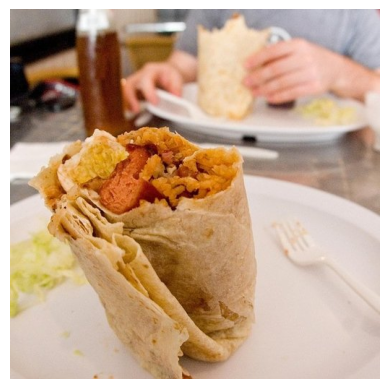

Predicted Class: Breakfast burrito, Confidence: 0.90


Enter the quantity in grams for Breakfast burrito:  500



Total Nutritional Values:
Calories: 750.00
Protein (g): 33.93
Carbs (g): 80.36
Fat (g): 39.29
Fiber (g): 7.14
Sugar (g): 5.36
Sodium (mg): 1625.00


In [2]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import collections
import pandas as pd
import re

# Load the ResNet152 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet152(weights=None)  # No pretrained weights since it's custom-trained
model.fc = torch.nn.Linear(model.fc.in_features, 101)  # Output layer for 101 classes
model = model.to(device)

# Load checkpoint
checkpoint_path = "model_checkpoint5446.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

# Remove 'module.' prefix if needed
if isinstance(checkpoint, collections.OrderedDict):
    checkpoint = {k.replace('module.', ''): v for k, v in checkpoint.items()}

model.load_state_dict(checkpoint)
model.eval()

# Define transformations
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Food class labels
class_labels = [
    "Apple pie", "Baby back ribs", "Baklava", "Beef carpaccio", "Beef tartare",
    "Beet salad", "Beignets", "Bibimbap", "Bread pudding", "Breakfast burrito",
    "Bruschetta", "Caesar salad", "Cannoli", "Caprese salad", "Carrot cake",
    "Ceviche", "Cheesecake", "Cheese plate", "Chicken curry", "Chicken quesadilla",
    "Chicken wings", "Chocolate cake", "Chocolate mousse", "Churros", "Clam chowder",
    "Club sandwich", "Crab cakes", "Creme brulee", "Croque madame", "Cup cakes",
    "Deviled eggs", "Donuts", "Dumplings", "Edamame", "Eggs benedict", "Escargots",
    "Falafel", "Filet mignon", "Fish and chips", "Foie gras", "French fries",
    "French onion soup", "French toast", "Fried calamari", "Fried rice",
    "Frozen yogurt", "Garlic bread", "Gnocchi", "Greek salad",
    "Grilled cheese sandwich", "Grilled salmon", "Guacamole", "Gyoza", "Hamburger",
    "Hot and sour soup", "Hot dog", "Huevos rancheros", "Hummus", "Ice cream",
    "Lasagna", "Lobster bisque", "Lobster roll sandwich", "Macaroni and cheese",
    "Macarons", "Miso soup", "Mussels", "Nachos", "Omelette", "Onion rings",
    "Oysters", "Pad thai", "Paella", "Pancakes", "Panna cotta", "Peking duck",
    "Pho", "Pizza", "Pork chop", "Poutine", "Prime rib", "Pulled pork sandwich",
    "Ramen", "Ravioli", "Red velvet cake", "Risotto", "Samosa", "Sashimi",
    "Scallops", "Seaweed salad", "Shrimp and grits", "Spaghetti bolognese",
    "Spaghetti carbonara", "Spring rolls", "Steak", "Strawberry shortcake",
    "Sushi", "Tacos", "Takoyaki", "Tiramisu", "Tuna tartare", "Waffles"
]

# Load the dataset
nutrition_data = pd.read_csv('nutrition_data.csv')

# Function to extract serving size in grams
def extract_serving_size(serving_size):
    match = re.search(r'(\d+)\s*g', str(serving_size))
    if match:
        return float(match.group(1))
    unit_conversions = {"oz": 28.3495, "cup": 240, "slice": 30, "piece": 30, "bowl": 200}
    match = re.match(r'(\d+(\.\d+)?)\s*(\w+)', str(serving_size))
    if match:
        value = float(match.group(1))
        unit = match.group(3).lower()
        return value * unit_conversions.get(unit, value)
    return None

# Apply function to standardize serving sizes
nutrition_data["Serving Size (g)"] = nutrition_data["Serving Size"].apply(extract_serving_size)

# Function to calculate total nutrient intake
def calculate_total_nutrients(dish, quantity, total_intake):
    row = nutrition_data[nutrition_data['Dish'].str.lower() == dish.lower()]
    if not row.empty:
        ref_serving_size = row["Serving Size (g)"].values[0]
        scale_factor = quantity / ref_serving_size if ref_serving_size else 1
        for nutrient in ["Calories", "Protein (g)", "Carbs (g)", "Fat (g)", "Fiber (g)", "Sugar (g)", "Sodium (mg)"]:
            total_intake[nutrient] += row[nutrient].values[0] * scale_factor
    else:
        print(f"Warning: Dish '{dish}' not found in the dataset.")
    return total_intake

# Function to predict image class and calculate nutrition
def predict_image(image_path, model, device, total_intake):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_tensor = transform_test(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_idx].item()
    
    predicted_label = class_labels[predicted_idx]
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print(f"Predicted Class: {predicted_label}, Confidence: {confidence:.2f}")
    
    quantity = float(input(f"Enter the quantity in grams for {predicted_label}: "))
    total_intake = calculate_total_nutrients(predicted_label, quantity, total_intake)
    
    print("\nTotal Nutritional Values:")
    for nutrient, value in total_intake.items():
        print(f"{nutrient}: {value:.2f}")
    
    return predicted_label, confidence, total_intake

# Initialize total intake dictionary
total_intake = {"Calories": 0, "Protein (g)": 0, "Carbs (g)": 0, "Fat (g)": 0, "Fiber (g)": 0, "Sugar (g)": 0, "Sodium (mg)": 0}

# Provide an image path for testing
image_path = "food-101/images/breakfast_burrito/1328.jpg"

# Predict and display result
predicted_class, confidence, total_intake = predict_image(image_path, model, device, total_intake)

In [3]:
import pandas as pd

# Function to calculate the deficiency report based on user goals and total intake
def generate_deficiency_report_from_goals(user_input, total_intake, class_mappings):
    report = {}
    
    # Extract the user goals directly from the user_input DataFrame (assumes only one row)
    user_goals = user_input.iloc[0].to_dict()
    
    # Iterate over the user goals and generate the deficiency report
    for nutrient, goal_value in user_goals.items():
        if nutrient in class_mappings:  # Ensure nutrient is in the mappings
            # Map user goals to the corresponding total intake field using class_mappings
            mapped_nutrient = class_mappings[nutrient]
            total_value = total_intake.get(mapped_nutrient, 0)
            deficiency = goal_value - total_value
            report[nutrient] = {
                "User Goal": round(goal_value, 2),
                "Total Intake": round(total_value, 2),
                "Deficiency (or Excess)": round(deficiency, 2)
            }
    
    return report

# Example user_input DataFrame with goals
user_input = pd.DataFrame([{
    'Age': 40, 'Weight': 95, 'Height': 165, 'Caloric_Goal': 500, 'Carb_Goal': 280, 
    'Protein_Goal': 180, 'Fat_Goal': 85, 'Exercise_Duration': 50, 'Calories_Burned': 400, 
    'Water_Intake': 3.0, 'Sleep_Duration': 6, 'Vitamin_Intake': 1.8, 'Mineral_Intake': 2.2, 
    'Activity_Level': 'Moderately Active', 'Meal_Type': 'Breakfast', 
    'Chronic_Conditions': 'None', 'Allergies': 'None', 'Medications': 'None', 
    'Fiber_Goal': 10.0, 'Sugar_Goal': 8.0, 'Sodium_Goal': 900.0
}])

# Class Mappings to align the goal and intake values
class_mappings = {
    "Caloric_Goal": "Calories",
    "Protein_Goal": "Protein (g)",
    "Carb_Goal": "Carbs (g)",
    "Fat_Goal": "Fat (g)",
    "Fiber_Goal": "Fiber (g)",
    "Sugar_Goal": "Sugar (g)",
    "Sodium_Goal": "Sodium (mg)"
}

# Generate the deficiency report
deficiency_report = generate_deficiency_report_from_goals(user_input, total_intake, class_mappings)

# Display the report
print("\nDeficiency Report (Based on User Goals):")
for nutrient, details in deficiency_report.items():
    print(f"{nutrient}:")
    print(f"  User Goal: {details['User Goal']}")
    print(f"  Total Intake: {details['Total Intake']}")
    print(f"  Deficiency (or Excess): {details['Deficiency (or Excess)']}")


Deficiency Report (Based on User Goals):
Caloric_Goal:
  User Goal: 500
  Total Intake: 750.0
  Deficiency (or Excess): -250.0
Carb_Goal:
  User Goal: 280
  Total Intake: 80.36
  Deficiency (or Excess): 199.64
Protein_Goal:
  User Goal: 180
  Total Intake: 33.93
  Deficiency (or Excess): 146.07
Fat_Goal:
  User Goal: 85
  Total Intake: 39.29
  Deficiency (or Excess): 45.71
Fiber_Goal:
  User Goal: 10.0
  Total Intake: 7.14
  Deficiency (or Excess): 2.86
Sugar_Goal:
  User Goal: 8.0
  Total Intake: 5.36
  Deficiency (or Excess): 2.64
Sodium_Goal:
  User Goal: 900.0
  Total Intake: 1625.0
  Deficiency (or Excess): -725.0
